In [6]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal
from pydantic import BaseModel,Field
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
model=ChatOpenAI(model='gpt-4o-mini')

In [10]:
class SentimentSchema(BaseModel):
    sentiment:Literal['positive','negative']=Field(description="Sentiment of the review")


In [14]:
structured_output_model=model.with_structured_output(SentimentSchema)
# prompt='what is the sentiment of the following review - The software too bad'
# structured_output_model.invoke(prompt)

In [34]:
class DiagnosisSchema(BaseModel):
    issue_type:Literal["Bug","UX","Performance","Support","Other"]=Field(description="The type of the issue mentioned in the review")
    tone:Literal["angry","frustrated","disappointed","calm"]=Field(description="The emotional tone of the review")
    urgency:Literal["low","medium","high"]=Field(description="How urgent or critical the issue is")

In [35]:
structured_output_model_diag=model.with_structured_output(DiagnosisSchema)

In [27]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive","negative"]
    diagnosis:dict
    response:str


In [18]:
def find_sentiment(state:ReviewState)->ReviewState:
    prompt=f"For the following review find the sentiment \n {state['review']}"
    output=structured_output_model.invoke(prompt)
    return {'sentiment':output.sentiment}
    

In [28]:
def check_condition(state:ReviewState)->Literal['run_diagnosis','positive_response']:
    if state['sentiment']=='positive':
        return "positive_response"
    else :
        return "run_diagnosis"

In [40]:
def run_diagnosis(state:ReviewState)->ReviewState:
    prompt=f"Diagnose this negative review:\n {state['review']}\n return issue_type,tone and urgency"
    diagnose=structured_output_model_diag.invoke(prompt)
    return {"diagnosis":diagnose.model_dump()}

In [41]:
def positive_response(state:ReviewState)->ReviewState:
    prompt=f"For the following postive review write a response \n {state['review']}"
    output=model.invoke(prompt)
    return {'response':output.content}

In [42]:
def negative_response(state:ReviewState)->ReviewState:
    prompt=f"For the following negative review write a response \n {state['review']} \n considering the diagonsis {state['diagnosis']} \n "
    output=model.invoke(prompt)
    return {'response':output.content}

In [43]:
graph=StateGraph(ReviewState)

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_condition)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

workflow=graph.compile()


In [46]:
intial_state={'review':'I’m extremely happy with this product! The quality is excellent, and it works exactly as described. The design is sleek, easy to use, and very reliable. It has made my daily routine so much easier. The packaging was neat, delivery was on time, and the customer service was very responsive. Overall, a great purchase — I would definitely recommend it to others!'}
final_state=workflow.invoke(intial_state)
final_state

{'review': 'I’m extremely happy with this product! The quality is excellent, and it works exactly as described. The design is sleek, easy to use, and very reliable. It has made my daily routine so much easier. The packaging was neat, delivery was on time, and the customer service was very responsive. Overall, a great purchase — I would definitely recommend it to others!',
 'sentiment': 'positive',
 'response': "Thank you so much for your wonderful review! We're thrilled to hear that you're so happy with the product and that it has made your daily routine easier. We take pride in the quality, design, and reliability of our items, and it's great to know that it met your expectations. We're also glad to hear that you had a positive experience with our packaging and customer service. Your recommendation means a lot to us! If you have any questions or need assistance in the future, don’t hesitate to reach out. Thanks again for your support!"}

In [47]:
intial_state={'review':'I’m really disappointed with this product. The quality is much worse than advertised, and it stopped working just a few days after I bought it. The build feels cheap, and the performance is slow and unreliable. Customer service was not helpful either—they didn’t respond to my emails for over a week. Overall, it was a waste of money and I wouldn’t recommend it to anyone.'}
final_state=workflow.invoke(intial_state)
final_state

{'review': 'I’m really disappointed with this product. The quality is much worse than advertised, and it stopped working just a few days after I bought it. The build feels cheap, and the performance is slow and unreliable. Customer service was not helpful either—they didn’t respond to my emails for over a week. Overall, it was a waste of money and I wouldn’t recommend it to anyone.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'disappointed', 'urgency': 'high'},
 'response': "Dear [Customer's Name],\n\nThank you for taking the time to share your experience with us. We sincerely apologize for the disappointment you've encountered with our product. It's always our goal to provide quality items, and we’re sorry to hear that we fell short in your case.\n\nWe take your feedback seriously and will investigate the quality concerns you mentioned. It's unacceptable for you to have experienced issues so soon after purchase, and we understand how frustrating that can be.

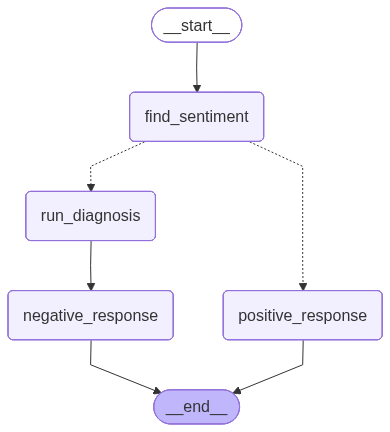

In [32]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())